# Example using the Tie Kernel

This kernel allows us to tie together the values of various parameters.

## Example 1: Simple RBF kernel with equal lengthscale and variance

Bit of an odd example, but simple to start with, we fix the lengthscale equal to the variance of the RBF kernel.

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import numpy as np
np.set_printoptions(precision=4,suppress=True)

X = np.arange(20)[:,None]
Y = np.sin(X)
simple = GPy.kern.RBF(input_dim=1)

tiekern = GPy.kern.Tie(simple,1,[['.*']])
tietest = GPy.models.GPRegression(X,Y,tiekern)
tietest.checkgrad(verbose=1)
#tietest.optimize()

Adding tie
                   Name                   |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
--------------------------------------------------------------------------------------------------------------------------
 GP_regression.tie.rbf.variance           |   5.636627    |   1.500951    |   0.323716    |   1.824667    |     1e-07     
 GP_regression.tie.rbf.lengthscale        |   -3.636627   |   1.500951    |   0.323716    |   -1.177235   |     9e-08     
 GP_regression.Gaussian_noise.variance    |   1.000000    |   0.000000    |   3.294544    |   3.294544    |     3e-07     


False

The above shows that the lengthscale and variance are now no longer fulfilling the gradient check. I've maybe not thought this through properly, and just took Max's suggestion to add together the gradients. We have a log likelihood, $L=log p(y|X,l,\sigma)$ and we know $\frac{\delta L}{\delta l}$ and $\frac{\delta L}{\delta \sigma}$. We are now fixing these to be equal. If we consider the infinitesimal movement from $l$ to $l+\Delta l$ and from $\sigma$ to $\sigma + \Delta \sigma$ the two $\Delta$ terms are equal. If the gradient wrt $\sigma$ at $l$ is equal to the gradient at $l + \Delta l$ then we can say that the change in $L$ between $(l,\sigma)$ is equal to the change that occurs along $l$ plus the change that occurs along $\sigma$, the upshot is we can add the two gradients together.

To achieve this in the kernel, I compute the new analytical values for the gradients, find their mean, and set all the gradients to this mean. 

One problem that appears above is the numerical approximation is calculated by adding a $\Delta l$ to the lengthscale, while the *analytical* one is effectively what happens if you add that delta to the variance too.

Below we demonstrate that by looking at how the likelihood changes when you move in both directions at the same time,

In [54]:
print np.sum(tietest.gradient[0:2])
before = tietest.log_likelihood()
tietest.tie.rbf.variance+=0.00001
tietest.tie.rbf.lengthscale+=0.00001
after = tietest.log_likelihood()
(after-before)/0.00001

-1.02422252034


-1.0242167622465104

And finally the values of the kernel after optimizing, included to show that the two parameters are equal to each other now:

In [59]:
tietest.optimize()
tietest

GP_regression.,value,constraints,priors
tie.rbf.variance,2.66232363554,+ve,
tie.rbf.lengthscale,2.66232363554,+ve,
Gaussian_noise.variance,6.63125989529e-14,+ve,


## Second example

This is the motivation for this, I wanted to fit a set of models using the independent outputs kernel and the offset kernel.

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import numpy as np
np.set_printoptions(precision=4,suppress=True)

N = 10
X1 = np.arange(1,N+1,1)[:,None]
X2 = X1 + 2
X = np.vstack([X1,X2,X1,X2])
nans = np.empty([N*2,1])
nans[:] = np.NAN

#offset indicies
ind_offset = np.vstack([np.zeros([N,1]),np.ones([N,1]),nans])

#independent output indicies
ind_indpoutputs = np.vstack([np.zeros([N*2,1]),np.ones([N,1]),np.ones([N,1])*2])
X = np.hstack([X,ind_offset,ind_indpoutputs])
Y = np.sin((X[0:N,0])/10.0)[:,None]
Y = np.vstack([Y,Y,Y,Y])
Y += np.random.randn(Y.shape[0],Y.shape[1])*0.1

#Structure of inputs:
# actual input | offset_kernel_index | indp_output_index
#      2.4              0                     0
#      2.9              0                     0
#      3.4              1                     0
#      3.9              1                     0
#      2.4              nan                   1
#      2.9              nan                   1
#      3.4              nan                   2
#      3.9              nan                   2
#print X
#print Y

#base kernel to explain all time series with
common_kern = GPy.kern.Matern32(input_dim=1)

#the offset kernel, that can shift one time series wrt another
offset_kern = GPy.kern.Offset(common_kern,2,[0])

#we want to discourage massive offsets, which can achieve good fits by simply moving the two datasets far apart
offset_kern.offset.set_prior(GPy.priors.Gaussian(0,4.0))

#our overall kernel contains our offset kernel and two common kernels
independent_kern = GPy.kern.IndependentOutputs([offset_kern,common_kern.copy(),common_kern.copy()],index_dim=2)

#simple GP Regression
independent = GPy.models.GPRegression(X,Y,independent_kern)

#print "Check gradients"
#independent.checkgrad(verbose=1)
#independent.optimize()

In [66]:
tiekern = GPy.kern.Tie(independent_kern,3,[['.*lengthscale'],['.*variance']])

Adding tie
Adding tie


In [67]:
tiekern

tie.,value,constraints,priors
independ.offset.offset,0.0,,"N(0, 4)"
independ.offset.Mat32.variance,1.0,+ve,
independ.offset.Mat32.lengthscale,1.0,+ve,
independ.Mat32.variance,1.0,+ve,
independ.Mat32.lengthscale,1.0,+ve,
independ.Mat32_1.variance,1.0,+ve,
independ.Mat32_1.lengthscale,1.0,+ve,


In [68]:
test = GPy.models.GPRegression(X,Y,tiekern)

In [69]:
test.checkgrad(verbose=True)

                          Name                          |     Ratio     |  Difference   |  Analytical   |   Numerical   |   dF_ratio    
----------------------------------------------------------------------------------------------------------------------------------------
 GP_regression.tie.independ.offset.offset               |   1.000000    |   0.000000    |   -0.209123   |   -0.209123   |     8e-09     
 GP_regression.tie.independ.offset.Mat32.variance       |   1.248713    |   0.338342    |   1.360370    |   1.698712    |     6e-08     
 GP_regression.tie.independ.offset.Mat32.lengthscale    |   1.480846    |   0.344021    |   -0.715449   |   -1.059470   |     4e-08     
 GP_regression.tie.independ.Mat32.variance              |   0.872220    |   0.173828    |   1.360370    |   1.186542    |     5e-08     
 GP_regression.tie.independ.Mat32.lengthscale           |   0.754075    |   0.175947    |   -0.715449   |   -0.539502   |     2e-08     
 GP_regression.tie.independ.Mat32_1.varia

False

In [70]:
test.optimize()

In [71]:
test

GP_regression.,value,constraints,priors
tie.independ.offset.offset,1.23345560859,,"N(0, 4)"
tie.independ.offset.Mat32.variance,0.288951579812,+ve,
tie.independ.offset.Mat32.lengthscale,1.70945335174,+ve,
tie.independ.Mat32.variance,0.288951579812,+ve,
tie.independ.Mat32.lengthscale,1.70945335174,+ve,
tie.independ.Mat32_1.variance,0.288951579812,+ve,
tie.independ.Mat32_1.lengthscale,1.70945335174,+ve,
Gaussian_noise.variance,0.00102104710223,+ve,


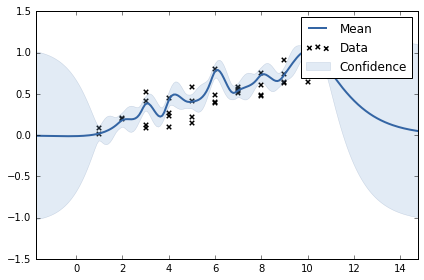

In [74]:
test.plot(fixed_inputs=[(1,0),(2,0)])